In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *

In [2]:
risk_free_rate = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
nc = Price.shape[1]

In [3]:
Super = pd.read_csv(r'C:\Users\Administrator\Desktop\ORIE 5370\Project\super_big_data.csv', index_col=0, header=0)
#Super = np.mat(Super)
Returns = np.mat(Super.iloc[:,range(120,120+30,1)])
Variance = np.mat(Super.iloc[:,range(0,0+nc*3,3)])
Skewness = np.mat(Super.iloc[:,range(1,1+nc*3,3)])
Kurtosis = np.mat(Super.iloc[:,range(2,2+nc*3,3)])

In [4]:
random_signal = np.random.uniform(20,100,1255*30)
random_signal = random_signal.reshape([1255,30])
random_signal = pd.DataFrame(random_signal,columns=range(1,31,1),index=range(1,1256,1))
random_signal = np.mat(random_signal)
#random_signal(can be replaced by any signal)

In [5]:
def ranking(signal_matrix):
    rank_matrix = np.zeros(signal_matrix.shape)
    rank_matrix = np.mat(rank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        #rankindex = [0]*nc   
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    del element_list[0]
                    r=r+1
                    break
    return rank_matrix
    ###########  end   ##########           

In [6]:
#########  PRECONDITION: number_of_colmns%number_of_groups==0 
def ngroupranking(signal_matrix,number_of_groups):
    rank_matrix = np.zeros(signal_matrix.shape)
    grouprank_matrix = np.zeros(signal_matrix.shape)
    #print rank_matrix.dtype
    rank_matrix = np.mat(rank_matrix)
    grouprank_matrix = np.mat(grouprank_matrix)
    #rank_matrix
    nc = signal_matrix.size/len(signal_matrix)
    distance = nc/number_of_groups
    for i in range(len(signal_matrix)):
        data_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list = np.matrix.tolist(signal_matrix[i,:])[0]
        element_list.sort()  # list the signal values of each date from small to large
        #rankindex = [0]*nc   
        rank_index=range(30)
        r=1  # rank 1 has the smallest signal value
        while(len(element_list)!=0):        
            for j in range(nc):
                if(min(element_list)==data_list[j]):
                    rank_matrix[i,j] = r
                    grouprank_matrix[i,j] = float(int(r-1)/int(distance)+1)
                    del element_list[0]
                    r=r+1
                    break
    return rank_matrix,grouprank_matrix
    ###########  end   ##########        
test = ngroupranking(Skewness,3)[1]
for i in range(1000):
    for j in range(20):
        if (test[i,j]!=1.0 and test[i,j]!=2.0 and test[i,j]!=3.0):
            print i,j,test[i,j]

In [7]:
def investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay):
    #signal: the larger value, the better

    S = Signal # the Signal matrix, each row refer to a date and each column refers to an asset
    R = Returns
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = signal_sample_frequency #num
    n_s = number_of_signal_samples #num
    r_d = rate_of_signal_decay #num
 
    s_d = t_d-1-np.arange(n_s)*s_f #reverse chronological
    #s_d = t_d-np.arange(n_s+1)*s_f #### We can take the ideal case where we can trade near the close, 
                                   #### we no longer need to minus 1
    s_d = s_d[::-1] #chronological    
    #sample dates, a row vector

    S_S = S[s_d,:] #Sample Signals, a matrix
    S_R = R[s_d,:] #Sample Returns

    #now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(n_s)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_S.T*wt  #mean vector of compound returns
    #print mean_c_r.T
    view_rank = ngroupranking(mean_c_r.T,3)[1].T
    #print ngroupranking(mean_c_r.T,3)[1].dtype
    #print mean_c_r.dtype
    #print view_rank.dtype
    #print view_rank
    view_rank = view_rank%3
    view_rank = view_rank%2
    ###########    View on the skewness    ########
    skewness_small = view_rank.T
    ####
    var_skewness = np.var(S_S)# the var of 
    A = skewness_small
    Omega = np.mat(var_skewness)
    b_skewness = np.sum(S_R*A.T)
    b = np.mat(b_skewness)
    return A,Omega,b
atest = investor_view(Skewness,Returns,120,1,5,0)[0]

In [8]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon # 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency #num
    n_s = number_of_samples #num
    r_d = rate_of_decay #num

    s_d = t_d-1-np.arange(n_s+1)*s_f #reverse chronological   
    s_d = t_d-np.arange(n_s+1)*s_f #### We can take the ideal case where we can trade near the close, 
                                   #### we no longer need to minus 1
    s_d = s_d[::-1] #chronological    
    #sample dates, a row vector

    S_P = P[s_d,:] #Sample Prices, a matrix
    

    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    #now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    #covariance matrix of compound returns

    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    #adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    #adapting covariance matrix to length of holding period

    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    mu = muu - 1
    #resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    #resulting covariance matrix of ARITHMETIC returns   
    
    return mu,V

In [9]:
def markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu0*x0+mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.02,
                   #0.05<=x,
                   #x<=0.2,
                   #x[1]+x[4]<=x[5]+x[6]+x[8],
                   #sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    #print "status:", prob.status
    #print "optimal value", prob.value
    #print "optimal var", x.value, y.value
    return x0.value,x.value

In [10]:
def blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b):
    n = len(mu)
    #print b
    #print "Omega.shape:",Omega.shape
    #print "Omegainv",np.linalg.inv(Omega)
    #print "V.shape:",V.shape
    #print "Vinv",np.linalg.inv(V)
    #print Omega.dtype
    #print V.dtype
    #print A.dtype
    #print (A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V)).shape
    middle = np.mat(A.T*Omega.I*A+V.I)
    #print middle.dtype
    #middle.dtype = 'float32'
    #print middle.shape
    #print np.linalg.det(middle)
    #print np.linalg.det(A.T*np.linalg.inv(Omega)*A+np.linalg.inv(V))
    #print 
    W = middle.I
    
    BL_mu = W*(A.T*np.linalg.inv(Omega)*b+np.linalg.inv(V)*mu) 
    
    U = np.linalg.cholesky(W)

    x0 = Variable(1)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
        
    objective = Maximize(mu0*x0+BL_mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   x0+sum_entries(x)+total_trans_cost==1,
                   x==xx+y,
                   trans_cost*sum_entries(abs(y))<=total_trans_cost,
                   x0>=0,
                   max_entries(abs(x-1.0/(n+1)))<=0.02,
                   #0.05<=x,
                   #x<=0.2,
                   #x[1]+x[4]<=x[5]+x[6]+x[8],
                   #sum_smallest(x,4)>=-1.25
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()  # Returns the optimal value.
    return x0.value,x.value

In [11]:
def rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [(n+1)*z <= benchmark_x0+sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

In [12]:
###############  BACKTEST  ###############
n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])

###############
#### PARAMETERS
#### (the following choices of parameters can easily be changed)

horizon = 5 # rebalance daily
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
start = 120 # the day on which you are first given a portfolio to rebalance
number_rebalances = 200 # the number of times the portfolio will be rebalanced 
number_of_samples = 20 # how many samples are to be used 
                      # in computing return avereages and covariances
sample_frequency = 1 # 1 = daily, 2 = , etc.
r_w_f_o_y_e = 0.2 # "relative weight for one year earlier" 
                 # -- a value .4 means that for the (exponential) weights 
                 # used in computing return averages and covariances, 
                 # the weight assigned to the time period one year ago
                 # should be .4 times the weight assigned 
                 # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.0008  # transaction cost
initial_wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially
Signal = Skewness
signal_sample_frequency = 1
number_of_signal_samples = 5
rate_of_signal_decay = 0
# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS

In [13]:
#######################
#######################
#######################
###### MARKOWITZ ######
#######################
#######################
#######################
######################
#rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
benchmark_wealth = initial_wealth
wealth = initial_wealth
portfolio_value = [initial_wealth]
benchmark_value = [initial_wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # It is more natural to rebalance the benchmark portfolio later #

    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    #[mu,V] = stats(Price,trade_date,sample_frequency,number_of_samples,rate_of_decay)
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    #benchmark_risk = sqrt(quad_form(e, V))/n # there are n assets in the portfolio
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                        # including the bank
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    #print "mu", mu.T
    x0,x =  markowitz(mu0,mu,V,sigma,xx0,xx,trans_cost)
    #print "x0:", x0
    #print "x:", x.T
    wealth = wealth*(x0+sum(x))
        # This is the same thing as updating your wealth by subtracting
        # all transaction costs from the rebalancing.  Indeed, in rebalancing,
        # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
        # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
        # vector of actual returns for risky assets (this is a row vector)
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth
            # by leaving off the semicolon, you can watch how wealth changes as the program runs

    if(wealth<=0):
        break   # stops the program if bankruptcy occurs
                # Not needed for benchmark portfolio (because it is long only)
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    # these are the proportions of current wealth invested in assets
    # Now its time to rebalance the benchmark portfolio and pay transaction costs

    
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    # This gives how the equal-weighted portfolio has changed during the time period.
    # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
    # This new level of wealth needs to be distributed equally among the assets and bank.
    # The optimal amount z to put into each one is determined by the following function,
    # which finds the value z so as to minimize transaction costs
    #print i,"returns:", returns
    #print "benchmark_x:",benchmark_x
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    #print "z:",z

    # Until the end of the next time period, 
    # think of the benchmark portfolio as having been rebalanced
    # with wealth divided equally, that is, the portion of wealth invested in
    # each asset and the bank is 1/(n+1).
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

In [14]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
print "your annualized rate of return:", float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return

your final bank account: [[  1.16184692e-11]]
your final risky portfolio: [[ 0.05314668]
 [ 0.01978774]
 [ 0.05268094]
 [ 0.04374196]
 [ 0.01246407]
 [ 0.05159495]
 [ 0.01167198]
 [ 0.01235138]
 [ 0.01209881]
 [ 0.04464824]
 [ 0.05135339]
 [ 0.01229748]
 [ 0.05185033]
 [ 0.01240417]
 [ 0.05190905]
 [ 0.0124601 ]
 [ 0.01251533]
 [ 0.01234563]
 [ 0.01233647]
 [ 0.01243953]
 [ 0.05164709]
 [ 0.05259842]
 [ 0.05279588]
 [ 0.05264482]
 [ 0.05233323]
 [ 0.01206885]
 [ 0.05313985]
 [ 0.05231137]
 [ 0.05224035]
 [ 0.01212194]]
your final wealth: [[ 19375.34987753]]
benchmark final wealth: 16667.6967694
your annualized rate of return: 0.183719048009
benchmark annualized rate of return: 0.139143078411


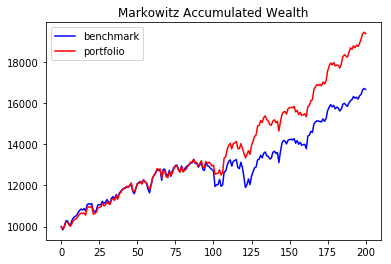

In [15]:
plt.figure(1)
plt.title("Markowitz Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="portfolio")
plt.legend()
plt.show()

In [16]:
#######################
#######################
#######################
### BLACK LITTERMAN ###
#######################
#######################
#######################
#rate_of_decay = 0
rate_of_decay = 1 - r_w_f_o_y_e**(sample_frequency/52.0)
benchmark_wealth = initial_wealth
wealth = initial_wealth
portfolio_value = [initial_wealth]
benchmark_value = [initial_wealth]
rebalance_dates = start + horizon*np.arange(number_rebalances)

for i in range(len(rebalance_dates)):
    trade_date = rebalance_dates[i]

    ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
    # It is more natural to rebalance the benchmark portfolio later #
    A,Omega,b = investor_view(Signal,Returns,trade_date,signal_sample_frequency,number_of_signal_samples,rate_of_signal_decay)   
    A.dtype = 'float64'
    
    mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
    #[mu,V] = stats(Price,trade_date,sample_frequency,number_of_samples,rate_of_decay)
    
   
    
    mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
    
    #benchmark_risk = sqrt(quad_form(e, V))/n # there are n assets in the portfolio
    benchmark_risk = sqrt(quad_form(e,V))/(n+1)  # there are n+1 financial instruments
                                                        # including the bank
    sigma = allowable_risk*benchmark_risk
    
    xx0 = x0
    xx = x
    x0,x =  blacklitterman(mu0,mu,V,sigma,xx0,xx,trans_cost,A,Omega,b)
    wealth = wealth*(x0+sum(x))
        # This is the same thing as updating your wealth by subtracting
        # all transaction costs from the rebalancing.  Indeed, in rebalancing,
        # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  
        
    total = x0+sum(x)
    x0 = x0/total
    x = x/total
        # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)
    
    ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######
    
    returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
        # vector of actual returns for risky assets (this is a row vector)
    
    multiplier = 1+mu0*x0+returns*x
    wealth = multiplier*wealth
            # by leaving off the semicolon, you can watch how wealth changes as the program runs

    if(wealth<=0):
        break   # stops the program if bankruptcy occurs
                # Not needed for benchmark portfolio (because it is long only)
    
    x0 = (1+mu0)*x0/multiplier
    x = np.multiply(x,np.transpose(1+returns))/multiplier
    # these are the proportions of current wealth invested in assets
    # Now its time to rebalance the benchmark portfolio and pay transaction costs
    
    benchmark_x0 = (1+mu0)/(n+1)
    benchmark_x = (1+returns)/(n+1)
    # This gives how the equal-weighted portfolio has changed during the time period.
    # The initial unit of wealth has become  benchmark_x0 + sum(benchmark_x).
    # This new level of wealth needs to be distributed equally among the assets and bank.
    # The optimal amount z to put into each one is determined by the following function,
    # which finds the value z so as to minimize transaction costs
    
    z = rebalance_benchmark(benchmark_x0,benchmark_x,trans_cost) 
    benchmark_wealth = benchmark_wealth*(n+1)*z
    # Until the end of the next time period, 
    # think of the benchmark portfolio as having been rebalanced
    # with wealth divided equally, that is, the portion of wealth invested in
    # each asset and the bank is 1/(n+1).
    
    portfolio_value.append(wealth)
    benchmark_value.append(benchmark_wealth)

In [17]:
print "your final bank account:", x0 
print "your final risky portfolio:", x 
print "your final wealth:", wealth 
print "benchmark final wealth:", benchmark_wealth 
print "your annualized rate of return:", float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
print "benchmark annualized rate of return:", benchmark_annual_return

your final bank account: [[  4.18357901e-12]]
your final risky portfolio: [[ 0.05314676]
 [ 0.01971404]
 [ 0.05268101]
 [ 0.04379076]
 [ 0.01246409]
 [ 0.05159502]
 [ 0.011672  ]
 [ 0.01235139]
 [ 0.01209883]
 [ 0.04467186]
 [ 0.05135346]
 [ 0.0122975 ]
 [ 0.05185041]
 [ 0.01240419]
 [ 0.05190913]
 [ 0.01246011]
 [ 0.01251534]
 [ 0.01234565]
 [ 0.01233649]
 [ 0.01243955]
 [ 0.05164717]
 [ 0.0525985 ]
 [ 0.05279595]
 [ 0.05264489]
 [ 0.0523333 ]
 [ 0.01206886]
 [ 0.05313993]
 [ 0.05231144]
 [ 0.05224042]
 [ 0.01212195]]
your final wealth: [[ 18749.68094622]]
benchmark final wealth: 16667.6967694
your annualized rate of return: 0.173852258554
benchmark annualized rate of return: 0.139143078411


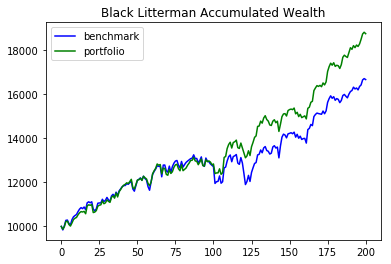

In [18]:
plt.figure(1)
plt.title("Black Litterman Accumulated Wealth")
plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
plt.plot(range(len(portfolio_value)),portfolio_value,'g',label="portfolio")
plt.legend()
plt.show()